In [13]:
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2

### Functions

In [14]:
def resize_image(image,size): # Returns 1D array length size*size
    if len(image) == 10000:
        image = image.reshape(100,100)
        
    ilist, jlist = [], []

    for i in range(100):
        if (np.sum(image[i]) != 0): #save rows with pixels in them
            ilist.append(i)
        
    for j in range(100):
        if (np.sum(image[:,j]) != 0): #save cols with pixels in them
            jlist.append(j)
    
    
    # If number of rows or cols is greater than desired size, 
    # find 28x28 matrix with highest concentration of pixels
    maxsum = 0
    maxx, maxy = ilist[0],jlist[0]
    
    for x in range(len(ilist)-size):
        newsum = 0
        for y in range(len(jlist)-size):
            newsum = np.sum(image[ilist[x]:ilist[x]+size][jlist[y]:jlist[y]+size])
            
            if maxsum < newsum:
                maxsum = newsum
                maxx = ilist[x]
                maxy = jlist[y]
   
    # Create new resized image (1D array)
    newim = []
    for i in range(size):
        for j in range(size):
            if maxx+i < 100 and maxy+j < 100:
                newim.append(image[maxx+i][maxy+j])
            else:
                newim.append(0)
          
    return np.array(newim)
    

In [15]:
def largest_contour(contours, n=2): 
    areas = []

    # Get the areas of all the contours
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        areas.append(area)

    # Sort areas by size
    sortedareas = sorted(zip(areas, contours), key=lambda x: x[0], reverse=True)

    #find 2nd largest contour (largest = square around image)
    return sortedareas[n-1][1]

In [16]:
def filter_image(img, thr=120, resize = True, plot = False, fill=False):
    # Reshape image if not already done
    if len(img) == 10000: 
        img = img.reshape(100,100)
    image = img.copy()
    
    # Plot original Image
    if plot == True:
        plt.subplot(121),plt.imshow(np.uint8(255)-image,cmap='binary_r'),plt.title('Original')
        
    # Convert image to proper type, filter with the threshold, then find the contours
    imgray = image.astype(np.uint8)
    ret, thresh = cv2.threshold(imgray, thr, 255, cv2.THRESH_BINARY_INV)
    im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    # Get the contour of the image and draw it
    secondcontour = largest_contour(contours)
    contoured = cv2.drawContours(image, secondcontour, -1, 255,2)
    
    # Plot the original image + contouring
    if plot==True:
        plt.subplot(122),plt.imshow(np.uint8(255)-contoured,cmap='binary_r'),plt.title('Original with Contouring')
        plt.show()    
    
    # Remove Noise by multiplying original image by filled contour shaped
    mask = np.zeros(image.shape, dtype='uint8')
    bkg = cv2.fillPoly(mask, [secondcontour],255)
    filtered_image = bkg*img.copy()
    
    # To test if filling is better (it isn't)
    if fill == True: 
        filtered_image = bkg
    
    # Plot filtered image
    if plot == True:
        plt.subplot(121),plt.imshow(np.uint8(255)-filtered_image,cmap='binary_r'),plt.title('Filtered Image')
    
    # Resize Image to size 28x28
    if resize == True:
        resized_image = resize_image(filtered_image,28)
        
        if plot == True: # Plot resized image
            plt.subplot(122),plt.imshow(np.uint8(255)-resized_image.reshape(28,28),cmap='gray'),plt.title('Final Resized Image')
            plt.show()
    
    if resize == True: 
        return resized_image # 1D Array
    else:
        return filtered_image

### Data Processing

In [6]:
# Load Data
train_images = np.load('train_images.npy',encoding='latin1')[:,1]
test_images = np.load('test_images.npy',encoding='latin1')[:,1]

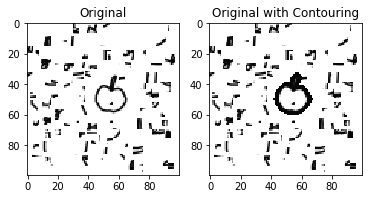

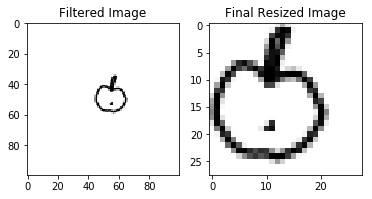

In [17]:
# Sample test 
sample = filter_image(train_images[3],plot=True)

In [9]:
# Perform preprocessing on training images
resized_train_imgs = []
for im in train_images:
    resized_train_imgs.append(filter_image(im))

In [10]:
# Perform preprocessing on test images
resized_test_imgs = []
for im in test_images:
    resized_test_imgs.append(filter_image(im))

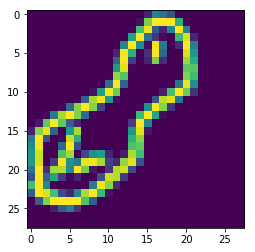

In [11]:
# Testing a random resized image
plt.imshow(resized_train_imgs[10].reshape(28,28))

In [12]:
# Save the resized datasets
np.save(open("ResizedTrain.npy","wb"), resized_train_imgs)
np.save(open("ResizedTest.npy","wb"), resized_test_imgs)